<h1>Análisis de los programas políticos para las Elecciones Generales en España (10 de noviembre, 2019)</h1>

# Motivación

Estamos (otra puñetera vez) en los últimos días de la campaña electoral previa a las Elecciones Generales en España, y los partidos políticos tratan de convencer a los no pocos indecisos, usando todas sus armas. Si nos apartamos de los debates, de los mítines en grandes recintos, de los mensajes lanzados en redes sociales, y de las entrevistas concedidas a los medios, nos quedamos con lo que debería ser lo más importante: sus programas.

En este notebook vamos a analizar algunos aspectos de los programas electorales de los principales partidos políticos españoles (en cuanto a intención de voto, según las últimas encuestas realizadas).

NOTA: Por aquí nadie se ha leído ningún programa.

# Install + Imports

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
!pip install multidict
!pip install plotly_express
!pip install wordcloud
!pip install pillow
!pip install nltk
!pip install tika
!pip install stop-words

In [0]:
!apt-get install poppler-utils

In [0]:
import string
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multidict as multidict
import plotly_express as px
import nltk

from bs4 import BeautifulSoup as bso
from os import path
from tika import parser, config
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from stop_words import get_stop_words

In [0]:
%matplotlib inline
sns.set()

# Carga de datos

In [0]:
# uncomment on google colab
#!unzip elecciones-2019-28a.zip

## Fuentes de datos

**Programas electorales**:
* [PSOE](https://www.psoe.es/programa-electoral/) (completo, pdf)
* [Ciudadanos](https://www.ciudadanos-cs.org/programa-electoral) (completo, web)
* [PP](https://www.pp.es/conocenos/programas) (completo, pdf)
* [Vox](https://www.voxespana.es/espana/programa-electoral-vox) ("*completo*", pdf)
* [Unidas Podemos](https://podemos.info/programa/) (completo, pdf)

**Datos del [CIS](http://www.analisis.cis.es/cisdb.jsp)**:
* Problemas_principales_que_existen_actualmente_en_Espana_3_ordinal.xls (octubre 2019)

In [0]:
# Programs
program_path = 'data/full2/'
cs_web = 'https://www.ciudadanos-cs.org/programa-electoral'

# Logos
logo_path = 'img/logos/'

## Funciones para web scrapping

Funciones utilizadas para obtener los programas que no están en PDF. Usaremos `BeautifulSoup` para obtener todo el texto de la web correspondiente:

In [0]:
def parse_web_program(party):
    if party == 'ciudadanos':
        raw_txt = parse_cs_program()
        txt_path = program_path + party + '.txt'
        with open(txt_path, 'w') as f:
           f.write(raw_txt)
        return raw_txt
    else:
        raise ValueError('Unknown party: ' + party)

def parse_cs_program():
    html_doc = requests.get(cs_web)
    soup = bso(html_doc.text, 'html.parser')
    raw_txt = []
    
    contents = soup.select('.propuesta')
    for content in contents:
        raw_txt.append(content.select('.titulo')[0].get_text())
        raw_txt.extend([h3.get_text() for h3 in content.select('h3')])
        raw_txt.extend([li.get_text() for li in content.select('li')])
    
    return ' '.join(raw_txt)

## Funciones para parseo de PDF

Para obtener el texto de los PDFs usaremos el comando `pdftotext`; después de haber probado `tika` y `textract` con peores resultados:

In [0]:
def parse_pdf_program(party, first=1):
    pdf_path = program_path + party + '.pdf'
    txt_path = program_path + party + '.txt'

    !pdftotext -f $first -nopgbrk $pdf_path

    return str(parser.from_file(txt_path)['content'])

## Funciones para parseo de Excel

Para parsear los ficheros Excel obtenidos de la web de CIS usaremos directamente `pandas`:

In [0]:
cis_xls = f'data/cis2/Problemas_principales_que_existen_actualmente_en_Espana_3_ordinal.xls'

def parse_cis_excel():
    df = pd.read_excel(cis_xls, skiprows=6, usecols=[0, 4], nrows=45)
    df.columns = ['problem', 'concern']
    return df.sort_values(by='concern', ascending=False)

## Control de la carga

Función para obtener el programa electoral dependiendo de cada partido:

In [0]:
def get_program(party):
    party = party.lower()
    if party == 'ciudadanos':
        return parse_web_program('ciudadanos')
    elif party == 'psoe':
        return parse_pdf_program('psoe', 13)
    elif party == 'unidas_podemos':
        return parse_pdf_program('unidas_podemos', 4)
    elif party == 'pp':
        return parse_pdf_program('pp', 3)
    elif party == 'vox':
        return parse_pdf_program('vox', 1)
    else:
        raise NotImplementedError('Party not found: ' + party)

Aquí es donde controlaremos los partidos a comparar:

In [0]:
parties = ['pp', 'ciudadanos', 'vox', 'psoe', 'unidas_podemos']

# Obtención y preprocesamiento del texto

Creamos funciones para preprocesar el texto, con el fin de:
* eliminar los caracteres que nos sobran
* pasar todo a minúsculas
* aplicar word lemmatization + stemming (en pruebas)

NOTA: Más adelante eliminaremos los signos de puntuación.

In [0]:
def simple_stemmer(text):
    #stemmer = nltk.porter.PorterStemmer()
    stemmer = nltk.stem.SnowballStemmer('spanish')
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [0]:
def preprocess_raw_text(raw_txt):
    fix_txt = raw_txt.replace('\r\n', '').lower()
    #fix_txt = simple_stemmer(raw_txt.replace('\r\n', '').lower())
    #print(fix_txt)
    return fix_txt

Obtenemos el texto de los programas de todos los partidos y lo preprocesamos:

In [0]:
programs_dict = {party: preprocess_raw_text(get_program(party)) for party in parties}

## Palabras vacías

Como estamos procesando lenguaje natural (aunque sea jerga política) tendremos algunas palabras que se repiten mucho, como en cualquier texto de cualquier tipo, y que no aportan mucha información; son las conocidas como palabras *vacías*. Ejemplo: pronombres, preposiciones, conjunciones, etc. La idea es quitar todas estas palabras para que no interfieran en nuestro análisis.

Vamos a utilizar una lista ya existente en la librería `stop-words`:

In [16]:
stopwords = get_stop_words('es')
print(stopwords)

['a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fu

Además vamos a añadir algunas palabras más que también aparecen bastante en algún programa y que no aportan mucho semánticamente...

In [0]:
stopwords.extend(['así', 'pág', 'ello', 'año', 'años', 'manera', 'forma', 'cualquier', 
                 'ser', 'cada', 'solo'])

# Nubes de palabras

Vamos a analizar las palabras más utilizadas por cada partido en su programa electoral. Para ello usaremos un recurso muy visual: las nubes de palabras, donde se refleja la frecuencia relativa de las que más veces aparecen.

Usaremos la genial librería `word_cloud` para generar dichas nubes:

In [0]:
def generate_word_cloud(input, party):     
    
    mask = np.array(Image.open(logo_path + party + '.png'))
    
    wc = WordCloud(background_color="white", max_words=300, mask=mask,
                   width=900, height=450, min_font_size=7, max_font_size=100,
                   stopwords=stopwords, collocations=True, normalize_plurals=True,
                   #contour_width=3, contour_color='steelblue', colormap='viridis',
                   prefer_horizontal=1)
    
    if isinstance(input, str):
        wc.generate(input)
    else:
        wc.generate_from_frequencies(input)

    plt.figure(figsize=(15,15))
    plt.imshow(wc.recolor(color_func=ImageColorGenerator(mask)), interpolation="bilinear")
    plt.axis("off")
    #plt.savefig('img/clouds/'+party+'.png', format="png")
    plt.show();
    
    return wc

Podemos crear una nube de palabras dejando todo en manos de la librería word_cloud, que se encargará de signos de puntuación, plurales, bigramas, etc.

In [0]:
wcs = {}
for party in parties[0:0]:
    print(party.upper())
    wcs[party] = generate_word_cloud(programs_dict[party], party)

Con el siguiente código obtendríamos el peso relativo de cada palabra, de mayor a menor importancia:

In [0]:
for party in parties[0:0]:
    print(party.upper())
    wcs[party].words_

NOTA: No hay resultado porque los bucles están *desactivados*. Después de realizar varias pruebas y comprobaciones con este modo, resulta más indicado usar otra variante, para poder controlar un poco más el proceso y no obtener cosas raras...

## Nubes de palabras por frecuencia

Vamos a crear las nubes de palabras sin dejar todo en manos de la librería word_cloud. Para cada programa electoral primero crearemos un diccionario con todas las palabras y el número de apariciones de cada una, de tal forma que podamos usarlo más adelante para seguir analizando esos datos.

Adicionalmente imprimiremos el número de apariciones de las 50 palabras más frecuentes en cada programa electoral.

NOTA: En este punto eliminamos signos de puntuación (para evitar por ejemplo tener palabras que incluyan puntos o comas). También quitamos palabras con menos de 3 caracteres.

In [21]:
# Punctuation signs
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
def get_frequency_dict(input_txt):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # Missing '+'? expecting 'I+D'...
    clr_txt = input_txt.translate(str.maketrans('…!"#$%&\'()*,-./:;<=>?@[\\]^_`{|}~',
                                                '                                '))
    # making dict for counting frequencies
    for word in clr_txt.split(' '):
        if word not in stopwords and len(word) > 2:
            tmpDict[word] = tmpDict.get(word, 0) + 1

    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    
    return fullTermsDict

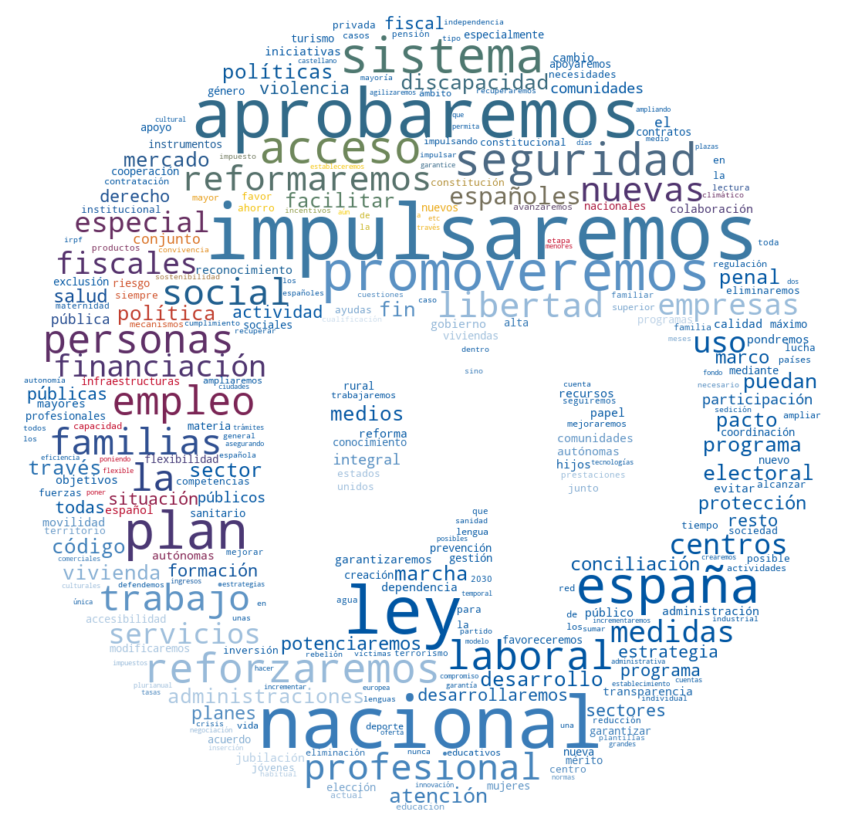

PP
impulsaremos: 36 | nacional: 32 | aprobaremos: 28 | ley: 27 | promoveremos: 25 | plan: 23 | españa: 22 | sistema: 20 | seguridad: 17 | acceso: 17 | reforzaremos: 14 | empleo: 13 | personas: 13 | laboral: 13 | 
la: 12 | social: 11 | trabajo: 11 | profesional: 11 | familias: 11 | nuevas: 10 | libertad: 10 | reformaremos: 10 | financiación: 10 | fiscales: 10 | uso: 10 | empresas: 10 | medidas: 10 | especial: 10 | servicios: 10 | centros: 10 | españoles: 9 | 

programa
electoral: 9 | puedan: 9 | atención: 9 | discapacidad: 9 | política: 8 | políticas: 8 | vivienda: 8 | sector: 8 | pacto: 8 | través: 8 | código: 8 | penal: 8 | medios: 8 | facilitar: 8 | marcha: 8 | mercado: 8 | fin: 8 | administraciones: 8 | desarrollo: 8 | 

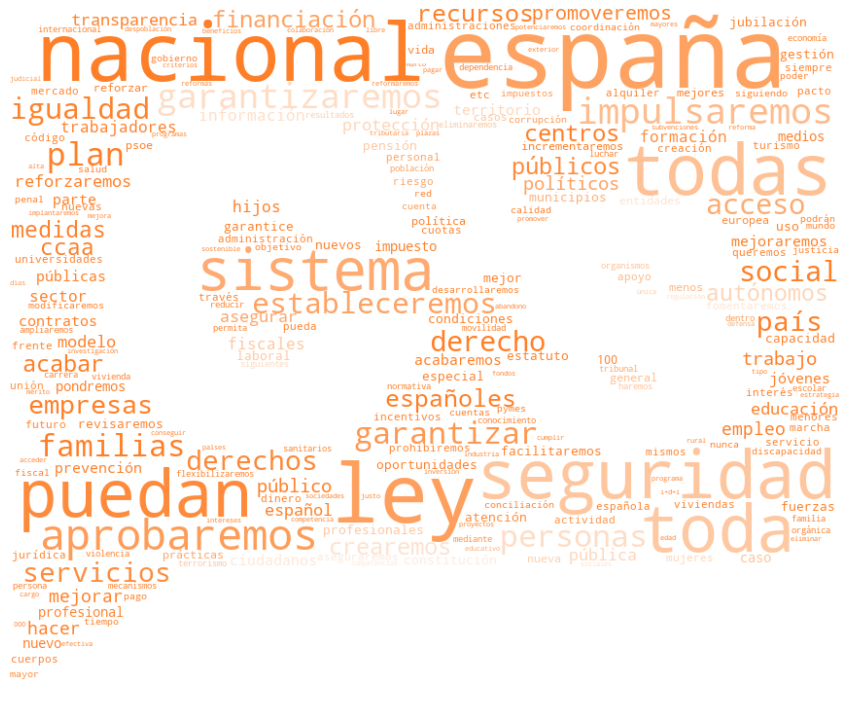

CIUDADANOS
españa: 75 | ley: 51 | nacional: 50 | todas: 37 | seguridad: 36 | puedan: 34 | toda: 34 | sistema: 33 | aprobaremos: 32 | impulsaremos: 32 | garantizaremos: 31 | plan: 28 | garantizar: 27 | personas: 27 | familias: 25 | igualdad: 25 | estableceremos: 25 | acceso: 24 | derecho: 24 | social: 24 | país: 23 | derechos: 23 | servicios: 23 | empresas: 21 | españoles: 21 | recursos: 21 | centros: 20 | públicos: 20 | crearemos: 20 | acabar: 20 | financiación: 20 | medidas: 19 | ccaa: 19 | autónomos: 19 | promoveremos: 19 | público: 18 | trabajo: 18 | políticos: 18 | hacer: 17 | empleo: 17 | mejorar: 17 | protección: 16 | educación: 16 | pública: 16 | modelo: 16 | transparencia: 16 | reforzaremos: 16 | asegurar: 16 | español: 16 | hijos: 15 | 

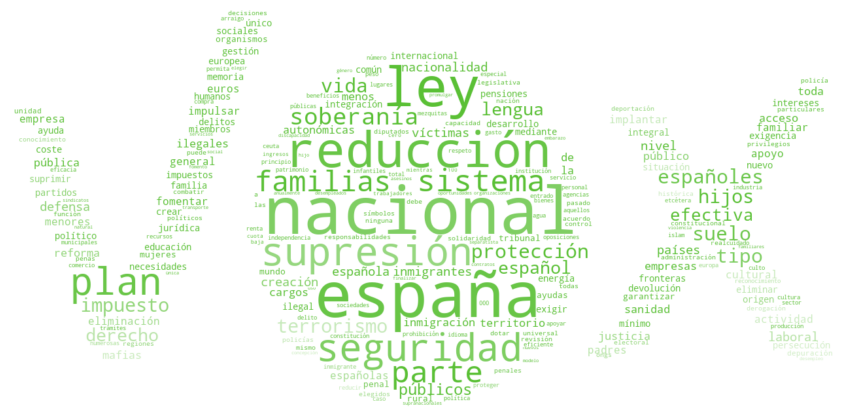

VOX
nacional: 15 | españa: 14 | ley: 10 | reducción: 8 | supresión: 7 | seguridad: 7 | plan: 7 | sistema: 7 | parte: 7 | familias: 7 | soberanía: 6 | protección: 6 | españoles: 6 | tipo: 6 | vida: 6 | suelo: 6 | impuesto: 6 | hijos: 6 | terrorismo: 6 | lengua: 5 | español: 5 | derecho: 5 | efectiva: 5 | públicos: 5 | inmigrantes: 5 | países: 5 | nacionalidad: 5 | española: 5 | nivel: 5 | víctimas: 5 | defensa: 5 | laboral: 5 | creación: 5 | de
la: 4 | menos: 4 | acceso: 4 | pública: 4 | autonómicas: 4 | toda: 4 | sanidad: 4 | reforma: 4 | cargos: 4 | ilegales: 4 | territorio: 4 | mafias: 4 | inmigración: 4 | empresas: 4 | público: 4 | justicia: 4 | eliminación: 4 | 

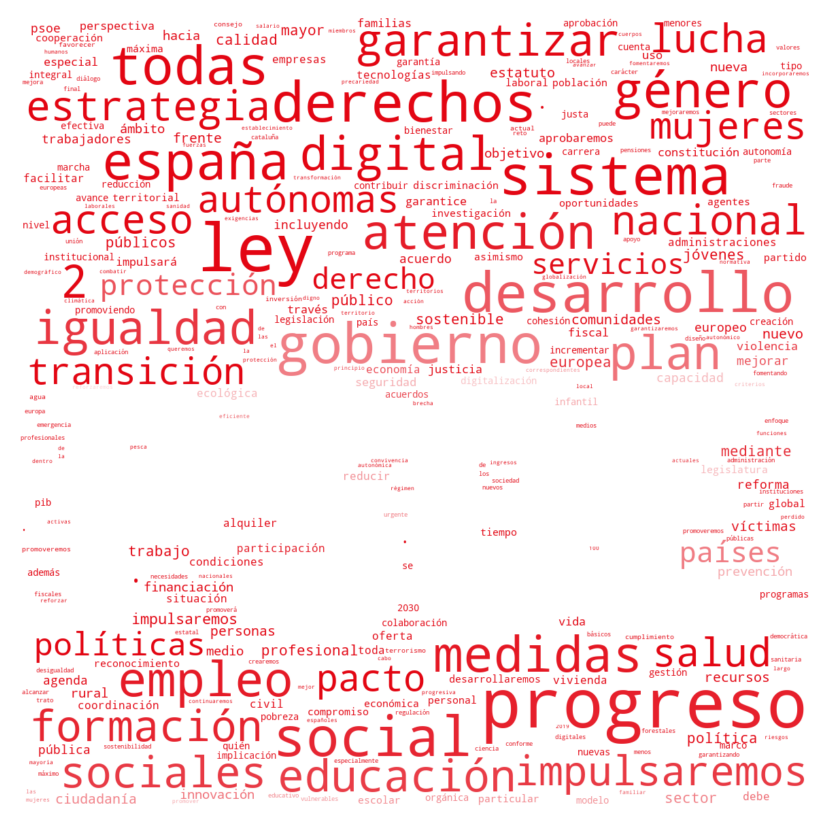

PSOE
progreso: 45 | ley: 42 | gobierno: 28 | social: 28 | derechos: 28 | sistema: 28 | desarrollo: 28 | todas: 26 | españa: 25 | género: 23 | medidas: 23 | empleo: 22 | atención: 22 | igualdad: 21 | digital: 21 | plan: 21 | 

2: 20 | garantizar: 19 | educación: 19 | formación: 18 | sociales: 18 | impulsaremos: 18 | estrategia: 18 | nacional: 18 | lucha: 17 | acceso: 17 | salud: 17 | mujeres: 15 | autónomas: 15 | transición: 15 | pacto: 15 | políticas: 15 | protección: 15 | derecho: 15 | servicios: 14 | países: 14 | 

•

impulsaremos: 14 | calidad: 13 | jóvenes: 13 | público: 13 | públicos: 13 | mediante: 13 | mayor: 13 | sector: 13 | europea: 13 | política: 13 | sostenible: 13 | trabajo: 13 | profesional: 13 | comunidades: 12 | 

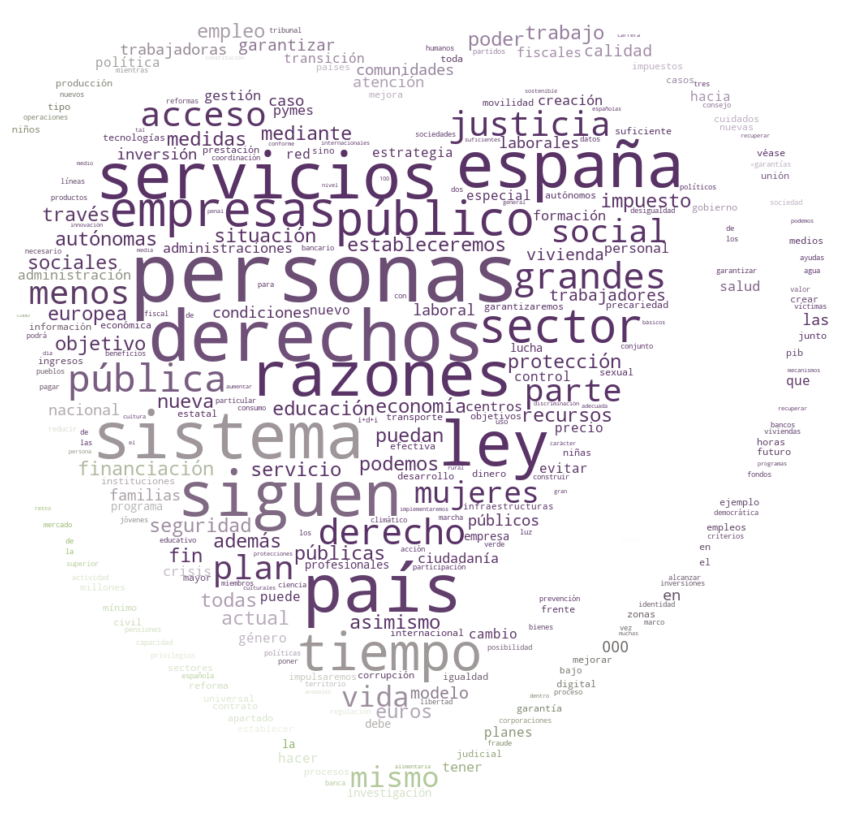

UNIDAS_PODEMOS
personas: 95 | derechos: 71 | país: 63 | sistema: 60 | españa: 59 | servicios: 59 | siguen: 56 | razones: 56 | ley: 54 | tiempo: 49 | empresas: 48 | público: 46 | sector: 44 | pública: 43 | grandes: 40 | derecho: 39 | acceso: 38 | justicia: 38 | plan: 37 | menos: 37 | parte: 36 | social: 36 | mujeres: 35 | mismo: 34 | vida: 33 | 

podemos: 32 | trabajo: 32 | todas: 31 | euros: 31 | empleo: 30 | economía: 30 | seguridad: 30 | situación: 29 | protección: 29 | medidas: 28 | puedan: 28 | impuesto: 28 | educación: 27 | europea: 27 | objetivo: 27 | autónomas: 27 | poder: 27 | través: 26 | sociales: 26 | financiación: 26 | asimismo: 26 | estableceremos: 26 | públicas: 25 | nueva: 25 | fin: 25 | 

In [23]:
freq_dicts = {}
wcs = {}

for party in parties:
    
    # Generate frequencies dict
    freq_dicts[party] = get_frequency_dict(programs_dict[party])

    # Generate word cloud. NOTE: neither bigrams nor normalization with this approach
    wcs[party] = generate_word_cloud(freq_dicts[party], party)
    
    # Print Top 50 words with frequency
    print(party.upper())
    for key in sorted(freq_dicts[party], key=freq_dicts[party].get, reverse=True)[:50]:
        print('{}: {}'.format(key, freq_dicts[party][key]), end=' | ')
    

**¿Es lo que esperabas?**

Con ésto podríamos intentar hacernos una idea de los temas más importantes en cada programa. A poco que conozcas de qué pie cojea cada partido, comprobarás que gracias a la nube de palabras del programa estamos obteniendo una pequeña radiografía del partido.

Quizá para incidir más en las diferencias podríamos prescindir de palabras comunes como *España*, ya que es normal que aparezca mucho estando donde estamos. Pero para el análisis completo resulta interesante conservar todo. ¿O no resulta curioso ver que Unidas Podemos tiene el único programa donde *España* no aparece en el Top 2? Igual es porque ellas usan la palabra *país* con tanta frecuencia como la anterior. Posiblemente no esperabas que el PSOE usaría la palabra *España* más que los partidos de derecha. ¡Tranquilidad! esos partidos tienen otras palabras como *nacional* para que su identidad quede clara.

¡Pues sí que ha dado juego una palabra que pensábamos que no aportaba nada! te invito a que busques palabras más interesantes como *derechos*, *ley*, *sanidad*, *educación*, *impuestos*, *empleo*, *corrupción*, ....

¿Y qué pasa con las que podemos echar de menos? vamos a intentar responder a esa pregunta en el siguiente punto.

# Preocupaciones de los españoles

¿Cuál es la labor de los partidos políticos? Es una buena pregunta. Supuestamente, los partidos intentan representar a la mayor cantidad posible de ciudadanos, y en teoría los programas electorales deberían intentar recoger soluciones a los problemas más importantes; tanto de la mayoría, como de las múltiples minorías. Bueno... sabiendo que los partidos más grandes se van a centrar en el interés general (de verdad que lo siento por esas minorías), su programa debería reflejar de manera especial cuáles son sus propuestas para las mayores preocupaciones del votante medio. ¿O no?

El **CIS** (Centro de Investigaciones Sociológicas) realiza mensualmente una encuesta donde pregunta a una pequeña muestra de la población cuáles son los 3 problemas que más preocupan, y ofrece los resultados de forma abierta; lo que nos sirve para hacernos una idea del sentimiento general. Parece un buen punto de partida....

Vamos a intentar averiguar si la prioridad que dan a estos temas los programas electorales se corresponde con la importancia que le dan los votantes.

## Encuesta del CIS

Cargamos los datos del CIS de la última encuesta realizada:

In [0]:
cis_df = parse_cis_excel()

Dibujamos una gráfica interactiva de barras horizontales para visualizar de forma clara los datos, usando `plotly_express`:

In [25]:
px.bar(
    cis_df, x="concern", y="problem", template="plotly_white",
    labels=dict(concern="% de encuestados para los que el problema es Top 3", problem="Problema"),
    width=970, height=900, title="Principales (3) preocupaciones de los españoles [octubre 2019]",
    orientation='h'
)

El paro, la corrupción, el fraude, la clase política, la economía, sanidad, educación, .... Aunque pudiéramos esperar una lista así, siempre es importante conocer las cifras. 

Vemos que hay mucha diferencia entre el primer problema y el segundo; o entre los 4 primeros y todos los demás. Pues a ver qué dicen los programas electorales...

¿Y cómo han cambiado nuestras preocupaciones desde las anteriores elecciones? En la siguiente gráfica podemos ver la evolución:

![evolución](https://cdn-images-1.medium.com/max/1000/1*gwEzs_L7DVGJw13bjLTV7w.png)

Parece que hay un par de problemas que han aumentado en importancia por encima del resto de manera acusada: los políticos y la inestabilidad del país o la falta de acuerdos. Esto se traduce en una pérdida sensible de foco en temas importantes como el paro, la corrupción y el fraude.

## Reflejo en los programas electorales

Vamos a crear un diccionario con una entrada para cada uno `(*)` de los principales problemas según la encuesta del CIS. Y para cada entrada hacemos una lista con algunas de las palabras más significativas que esperaríamos encontrar relacionadas con el tema de la entrada en cuestión.

Esta parte es la más delicada, porque hay palabras que podrían relacionarse con varios temas, y habrá que valorar su inclusión en una lista o en otra (o en ninguna). Por ejemplo, seguramente una de las primeras palabras que nos viene a la mente cuando hablamos de *violencia machista* es *género*, pero está claro que también se puede hablar de *género* relacionado simplemente con la *mujer* (desigualdades); ante la duda la dejaremos fuera.

`(*)` NOTA: algunos temas han sido unificados, como por ejemplo Cataluña y los Nacionalismos, Paro y Empleo de calidad, Clase política e Inestabilidad política, Terrorismo internacional y nacional. En cambio algún otro ha sido separado, como es el caso de Fraude y Corrupción (¿por qué diantres los une el CIS?).

In [0]:
problems = {'empleo': ['paro', 'paradas', 'parados', 'parada', 'parado', 'empleo', 'desempleado',
                       'desempleada', 'desempleados', 'desempleo', 'laboral', 'laborales', 'salario'],
            'políticos': ['regeneración', 'pacto', 'pactos', 'consenso', 'diálogo', 'casta',
                          'inestabilidad', 'acuerdos', 'desacuerdos'],
            'economía': ['economía', 'pib', 'económica', 'crisis', 'mercado', 'euro', 'económico',
                         'crecimiento'],
            'corrupción': ['corrupción', 'corrupto', 'corrupta', 'corruptos', 'corruptas', 
                           'imputados', 'imputado'],
            'fraude': ['fraude', 'defraudan', 'defraudar', 'defraudado', 'defraudador', 'defraudadores'],
            'sanidad': ['sanidad', 'médico', 'médicos', 'quirófano', 'hospital', 'sanitarios', 
                        'sanitarias', 'sanitaria', 'medicamentos'],
            'inmigración': ['inmigración', 'inmigrante', 'inmigrantes', 'extranjero', 'extranjeros', 
                            'refugiados', 'refugiado', 'cie', 'salvamento', 'frontera', 'ceuta'],
            'educación': ['educación', 'enseñanza', 'escuela', 'idiomas', 'profesores', 'guardería',
                          'guarderías', 'universidad', 'universidades'],
            'pensiones': ['pensiones', 'pensión', 'jubilación', 'pensionistas', 'pensionista', 'jubilado', 
                          'jubilados', 'jubiladas'],
            'social': ['social', 'equitativa', 'equitativo', 'sociales', 'pobreza'],
            'nacionalismos': ['cataluña', 'catalanes', 'referéndum', '155', 'independencia', 'independentistas', 
                         'nacionalismo', 'nacionalismos', 'separatistas', 'separatismo', 'soberanía', 'sedición',
                         'nacionalistas'],
            'violencia_machista': ['machista', 'machistas', 'acoso', 'violación', 'violada', 'violadas', 
                                   'violaciones', 'maltrato', 'maltratada', 'maltratadas'],
            'inseguridad': ['inseguridad', 'ciberataques', 'ciberseguridad', 'policía', 'violentos', 
                            'crímenes', 'robos'],
            'vivienda': ['vivienda', 'alquiler', 'alquileres', 'hipoteca', 'hipotecas', 'especulación', 
                         'especuladores', 'buitre', 'buitres', 'desahucio', 'desahucios', 'okupa', 'okupas'],
            'medioambiente': ['medioambiente', 'medioambiental', 'planeta', 'contaminación', 'contaminantes', 
                              'reciclar', 'renovables', 'climático', 'clima', 'climática', 'ambiental', 'ambientales'],
            'justicia': ['justicia', 'jueces', 'juez', 'juicio', 'juicios', 'sentencia', 'prisión', 
                         'cárcel', 'tribunal', 'tribunales'],
            'valores': ['valores', 'familia', 'aborto', 'tradiciones', 'tradición'],
            'juventud': ['juvenil', 'juventud', 'jóvenes', 'emancipación'],
            'mujer': ['mujer', 'mujeres', 'feminismo', 'feminismos', 'paridad'],
            'autónomos': ['autónomos', 'emprendedores', 'emprendedor'],
            'agropecuario_pesca': ['agrario', 'agraria', 'agricultura', 'agricultor', 'agricultores', 
                                  'ganadería', 'ganadero', 'ganaderos', 'pesca', 'pescadores', 'pescador',
                                  'agropecuario', 'agrícola', 'agrícolas'],
            'impuestos': ['impuestos', 'impuesto', 'iva', 'irpf', 'sucesiones', 'gravamen'],
            'infraestructuras': ['infraestructura', 'infraestructuras', 'carreteras', 'trenes', 
                                 'ave', 'ferroviaria', 'ferroviarias', 'puentes', 'autopistas', 
                                 'carretera'],            
            'monarquía': ['monarquía', 'reyes', 'república', 'rey', 'monarca', 'republicanos'],
            'inversión': ['i+d', 'i+d+i', 'inversión', 'inversiones', 'invertir', 'invierte', 'investigación',
                          'investigadores'],
            'racismo': ['racismo', 'racista', 'racistas', 'xenofobia', 'xenófobo', 'xenófobos'],
            'terrorismo': ['terrorismo', 'terrorista', 'terroristas', 'isis', 'eta', 'etarra', 'islamista',
                           'islamistas', 'atentado', 'atentados', 'etarras'],
            'drogas': ['droga', 'drogas', 'heroína', 'cocaína', 'adicción', 'adicciones']
            }

Vamos a contar el número de palabras en cada programa electoral (eliminadas palabras vacías y palabras menores de 3 letras). El motivo es que, aparte de contar el número de apariciones de las palabras relacionadas con cada problema, nos interesa saber su frecuencia; de tal forma que podamos ver la importancia relativa dentro de cada programa, y también podamos hacer una comparativa válida entre todos.

In [37]:
program_words = {party: sum(freq_dicts[party].values()) for party in parties}  
program_words

{'ciudadanos': 8547,
 'pp': 4857,
 'psoe': 6553,
 'unidas_podemos': 18109,
 'vox': 1871}

Creamos un dataframe con el conteo de palabras asociadas a cada problema, para cada partido:

In [0]:
def build_problems_df(problems):
    df = pd.DataFrame(columns=problems.keys(), dtype=int)

    for party in parties:
        counts_array = []
        for problem in problems.keys():
            counts = 0
            for word in problems.get(problem):
                counts += freq_dicts[party].get(word, 0)
            counts_array.append(counts)
        df.loc[party] = counts_array

    df['TOTAL'] = program_words.values()
    return df

In [0]:
df = build_problems_df(problems)

Vamos a pintar el contenido del dataframe usando la función `heatmap()` de `seaborn`:

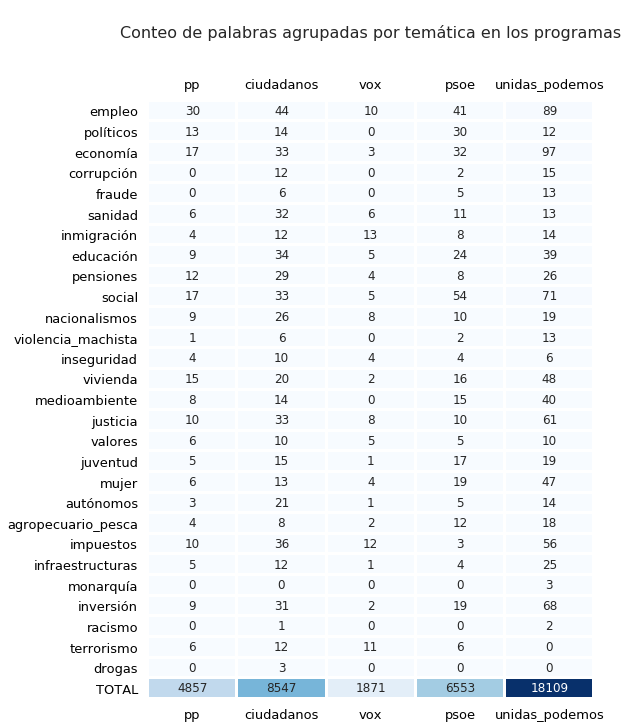

In [40]:
plt.figure(figsize=(8,11))
ax = sns.heatmap(df.T, annot=True, fmt='d', cmap='Blues', cbar=False, linecolor='white', linewidths=2)
ax.tick_params(labelbottom=True, labeltop=True, labelsize=13, labelcolor='black')
ax.set_title('\nConteo de palabras agrupadas por temática en los programas\n\n', 
             fontsize=16);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

**¿Algo interesante por aquí?**

Así, de primeras:
* Cuarta preocupación de los españoles; cara A: la corrupción. Lo más llamativo es que el programa del PP no usa ninguna de estas palabras: 'corrupción', 'corrupto', 'corrupta', 'corruptos', 'corruptas', 'imputados', o 'imputado'. En casi 15.000 palabras parece que no había cabida para este tema, o han intentado llamarlo de otra manera. Si abres el programa sólo encontrarás algo relacionado al hablar de la transparencia en la financiación de los partidos. Lo mismo ocurre en el programa de Vox, lo que resulta aún más raro tratándose de un partido nuevo.
* Cuarta preocupación; cara B: el fraude. El programa del PP no usa ninguna de estas palabras: 'fraude', 'defraudan', 'defraudar', 'defraudado', 'defraudador', 'defraudadores'. Vox de nuevo nada… ¡Bravo!
* El programa de Vox parece no hablar de otras preocupaciones importantes; por ejemplo la violencia machista. Buscando en su programa por la palabra género, eliminada a propósito de esa categoría, sí que encontramos dos promesas electorales relacionadas: "derogar la ley de violencia de género" (lo que les preocupa es la ley) y "suprimir en la sanidad pública las intervenciones quirúrgicas ajenas a la salud; como cambio de género, aborto…" (volvemos al aborto para los ricos). Nada de medioambiente. ¡Nada de la clase política! Pero ya sabíamos que este no es un programa electoral al uso, ¿verdad?

Y después de ver un poco por encima las anomalías (y de asegurarnos de que nuestro código está bien), vamos a pasar de número de apariciones a frecuencias, para poder analizar mejor los resultados. Creamos otro dataframe diviendo ese número de apariciones por el número de palabras total en cada programa (y multiplicando por 100 para obtener porcentajes):

In [0]:
df_rel = df.div(0.01*df['TOTAL'], axis=0).drop('TOTAL', axis=1)

De nuevo usamos el mapa de calor de `seaborn` para representar el contenido del dataframe:

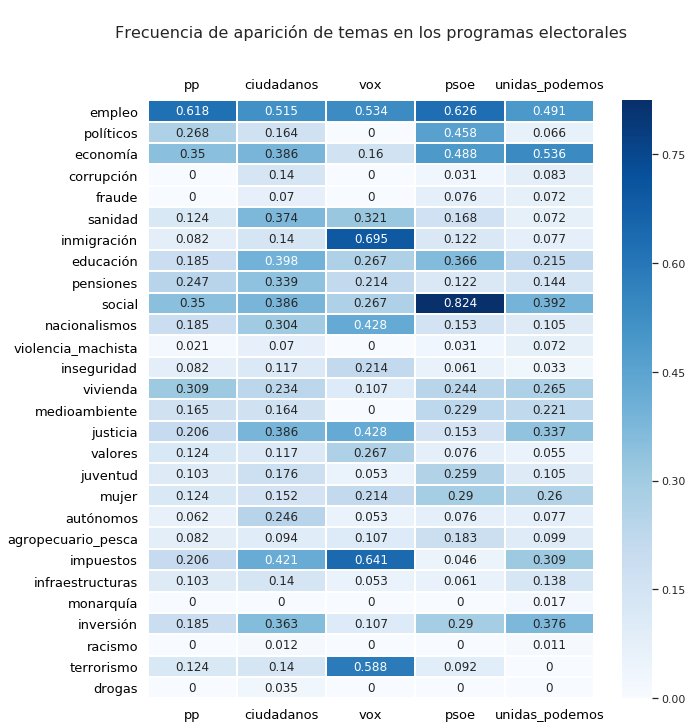

In [42]:
plt.figure(figsize=(10,11))
ax = sns.heatmap(df_rel.T.round(3), annot=True, fmt='g', cmap='Blues', linecolor='white', linewidths=1)

ax.tick_params(labelbottom=True, labeltop=True, labelsize=13, labelcolor='black')
ax.set_title('\nFrecuencia de aparición de temas en los programas electorales\n\n', 
             fontsize=16);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

Creamos una gráfica de barras horizontales agrupadas por temática, con el fin de poder ver el peso de cada problema, y a la vez comparar los 5 partidos en cada uno de ellos (algo posible gracias a la normalización previa). El orden de los problemas viene de la importancia reflejada en la encuesta del CIS (de menor a mayor). Lo que esperaríamos encontrar es que el tamaño de las barras fuera creciendo según vamos avanzando, aunque viendo el dataframe ya sabemos que no se va a cumplir.

Usamos la función `plot()` de `pandas`:

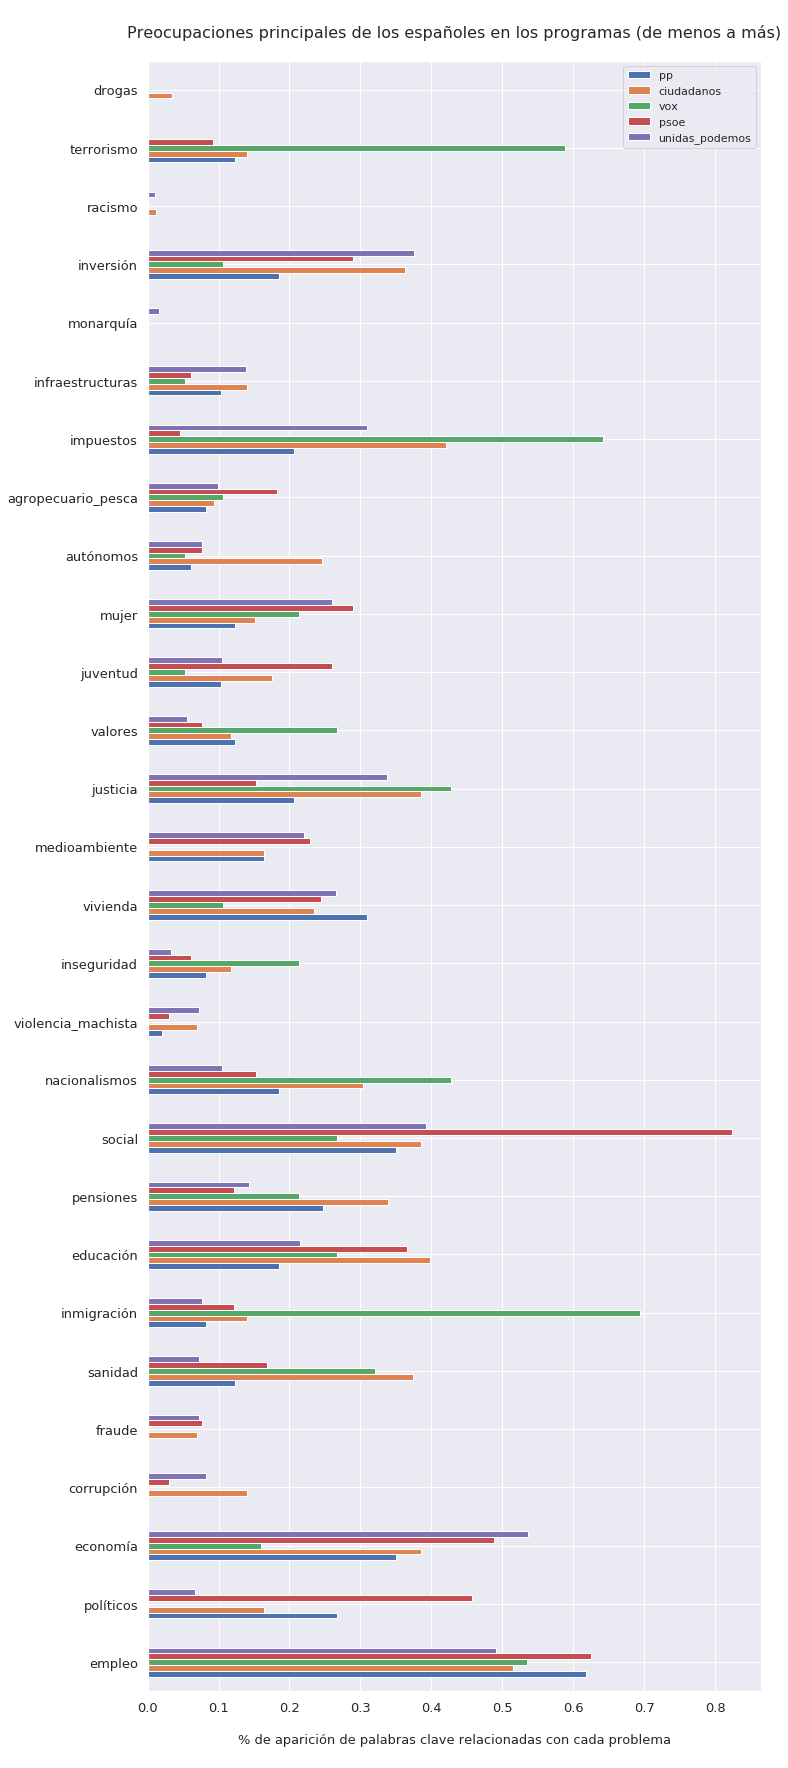

In [44]:
ax = df_rel.T.plot(kind='barh', figsize=(11,30), fontsize=13)

ax.set_title('\nPreocupaciones principales de los españoles en los programas (de menos a más)\n', 
             fontsize=16)
ax.set_xlabel("\n% de aparición de palabras clave relacionadas con cada problema\n", fontsize=13);

**¿Llamativo?**

Desde luego que no parece seguir el patrón de preocupaciones de los votantes. Algunas cosas que se observan:
* En temas de corrupción y fraude, como ya habíamos apuntado, los programas de PP y Vox ni entran. El del PSOE mejora con respecto al de las pasadas elecciones de abril. Unidas Podemos y Ciudadanos son los que siguen haciendo más hincapié.
* De la comparativa entre partidos vemos que el programa de Vox es el más distinto al resto, con diferencia. Parece ser el más preocupado por impuestos, inmigración (ejem), inseguridad, valores, nacionalismos y terrorismos. Pero luego hay muchos temas que directamente ni toca. No incluye cambios respecto a abril.
* El PSOE parece ser el que ha hecho más hincapié en la inestabilidad política y el nacionalismo con respecto a abril, como refleja el aumento de las preocupaciones según el CIS. Nuevamente es el que más espacio dedica a temas sociales. Además es el que más hace referencia a la mujer y a los jóvenes. Con respecto al mes de abril, destaca también su aumento de cuota en el tema agropecuario.
* Ciudadanos es el partido que más se centra en los autónomos y en la corrupción, y se sitúa levemente por encima del resto en temás de educación y sanidad. También aumenta su cuota en el tema de los nacionalismos y Cataluña, pero no en el problema de la inestabilidad política.
* Unidas Podemos curiosamente es el que más parte de su programa dedica a economía e inversión. Además es el único que menciona la monarquía. Y el único que parece no hablar de terrorismo.
* El programa del PP sólo destaca sorprendentemente en el tema de la vivienda, suponiendo un notable aumento desde abril. En cambio habla bastante menos de economía.

Quizá después de este somero análisis no sabremos las medidas que explica cada programa, pero igual nos ha ayudado a saber los que no necesitamos ni abrir.

Un programa electoral es el lugar donde cada partido debería plasmar todas sus intenciones, aunque cada vez parece que se les da menos importancia (desde ambas partes).

# Otros temas sensibles

Otro ejercicio que podemos hacer es buscar por temas concretos que en realidad preocupan a la población aunque no aparezcan reflejados en las encuestas del CIS:

In [0]:
problems = {'rural': ['rural', 'rurales', 'despoblación'],
            'cultura': ['cultura', 'cine', 'música', 'teatro'],
            'lgtbi': ['lgtb', 'lgtbi', 'lesbianas', 'homosexuales', 'homosexual', 'transgénero', 'gay', 
                      'gays', 'homofobia'],
            'animales': ['animales', 'animalista', 'animalistas', 'mascotas'],
            'toros': ['tauromaquia', 'toro', 'toros', 'taurino', 'taurinos', 'corrida', 'corridas'],
            'iglesia': ['iglesia', 'católicos', 'católica', 'católico', 'cristianos', 'cristiano',
                        'cristiandad', 'sectas', 'procesiones'],
            'eutanasia': ['eutanasia'],
            'ong': ['ong', 'ongs'],
            'aborto': ['aborto', 'abortar']
            }

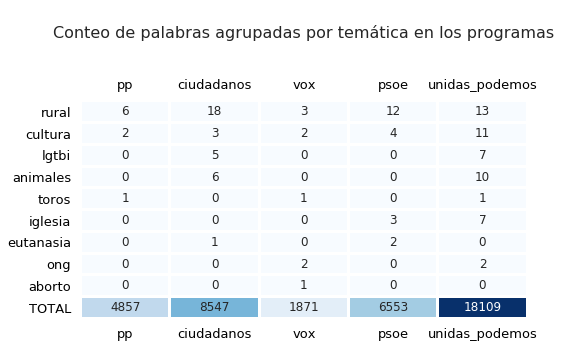

In [46]:
df = build_problems_df(problems)

plt.figure(figsize=(8,4))
ax = sns.heatmap(df.T, annot=True, fmt='d', cmap='Blues', cbar=False, linecolor='white', linewidths=2)

ax.tick_params(labelbottom=True, labeltop=True, labelsize=13, labelcolor='black')
ax.set_title('\nConteo de palabras agrupadas por temática en los programas\n\n', 
             fontsize=16);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);    

Algunos puntos interesantes:
* Los problemas del mundo rural y el tema de la cultura parecen ser importantes para todos los partidos (menos mal)
* PP, PSOE y Vox parece que no hacen ninguna referencia al colectivo LGTBi (el PSOE sí las tenía en abril).
* El programa de Unidas Podemos era el único que hablaba de la iglesia en las anteriores elecciones, pero parece que el PSOE se ha animado en esta ocasión, a pesar de haber reducido drásticamente el tamaño de su programa.
* El PP parece haberse olvidado por completo de los animales, salvo de los toros, claro está.
* Parece que a estas alturas ya nadie habla del aborto, menos Vox :P

Aquí podríamos entretenernos mucho tiempo :)

# Líneas futuras de trabajo

Se podría ampliar este análisis en varias direcciones:

* Análisis de sentimiento. No sabemos si se habla de un determinado tema en una dirección o en la contraria.
* Uso de bigramas y trigramas para poder realizar un mejor estudio de los programas.
* Análisis de discursos electorales.
* Creación de una API para hacer búsquedas en los programas

# Referencias
* [tika-python](https://github.com/chrismattmann/tika-python)
* [pdftotext](https://en.wikipedia.org/wiki/Pdftotext)
* [textract](https://textract.readthedocs.io/en/latest/)
* [beautiful soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
* [stop-words](https://pypi.org/project/stop-words/)
* [word_cloud](https://amueller.github.io/word_cloud/)
* [plotly_express](https://medium.com/@plotlygraphs/introducing-plotly-express-808df010143d)
* [seaborn](https://seaborn.pydata.org/)
* [pandas visualization](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)